この記事では、与えられたデータセットについて基本的な情報の探索を行ってみる。このコンペティション用のデータセットは、過去の顧客の注文履歴を記載しているファイルのセットだ。

##  目標
目標は顧客が次に注文するのはどの商品かを予想することだ。このデータセットは匿名化されており、またInstacart user 20万人からの日用品の注文3万件のデータを含んでいる。
それぞれのユーザーあたり、4〜100件の注文データが、それぞれの注文において一緒に購入された商品のリストと共に与えられている。

さて、まずは必要なモジュールをインポートしよう。

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline
pd.options.mode.chained_assignment = None

まずは、このコンペティションで必要となるファイルをリストアップしてみよう！

In [17]:
from subprocess  import check_output
print(check_output("ls").decode("utf8"))             

# python上から直接UNIXコマンドを実行する方法。
# オリジナルのカーネルとは書き方が違うけど、カレントディレクトリの内容を表示。文字コードを"utf8"で指定しないと、改行コードがそのまま入ってしまう。

EDA-2-instacart.ipynb
aisles.csv
aisles.csv.zip
departments.csv
departments.csv.zip
kernel.ipynb_2.ipynb
order_products__prior.csv
order_products__prior.csv.zip
order_products__train.csv
order_products__train.csv.zip
orders.csv
orders.csv.zip
products.csv
products.csv.zip
sample_submission 2.csv
sample_submission.csv.zip



In [19]:
# 必要なファイルをインポート
order_products_train_df=pd.read_csv("order_products__train.csv")
order_products_prior_df=pd.read_csv("order_products__prior.csv")
orders_df=pd.read_csv("orders.csv")
products_df=pd.read_csv("products.csv")
aisles_df=pd.read_csv("aisles.csv")
departments_df=pd.read_csv("departments.csv")

（以下三つ、各DataFrameの先頭いくつかだけ試しに表示している。）

(orders_dfが全データ。それをpriorとtrainとtestに分割している。)

In [20]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [22]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [23]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


今みたようにorder.csvのファイルが、「購入者の情報」のように与えられたorderidに関する情報をすべてもっている。例えば、いつ購入されたのかといった情報や、過去の注文からどのくらい日数が経っているかなどの情報である。

order_products_trainとorder_products_priorが有しているカラムは同じである。それでは、これらのファイルは何が違うのだろうか？

すでに触れたように、このデータセットでは(このあとみていくように)顧客あたりに対して4件〜100件の注文履歴のデータセットが与えられていて、我々は再度注文されるであろう商品を予測する必要がある。だから、顧客の最後に購入した履歴が引き出され、またトレーニングデータとテストデータに分けられているのである。顧客の以前の注文履歴の全てはorder_products_prior fileに入っている。orders.csvというファイルの中にはeval_setという名前のカラムがあることにも触れておかなかければならない。それは、データがpriorからのものなのか、trainからのものなのか、testからのものなのかということを示している。

Order_products〜というファイルは与えられている注文情報において購入された商品に関するより詳細な情報を再注文の履歴とともにもっている。

それでは、それぞれ3つのシートの行を数えてみよう。


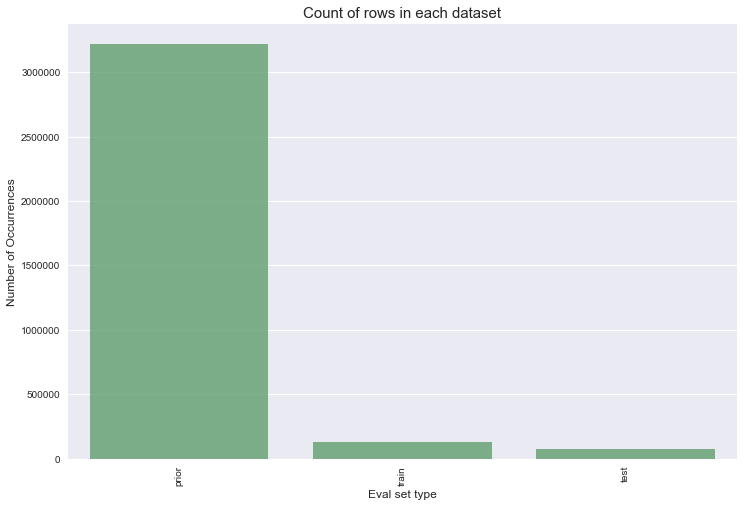

In [27]:
cnt_srs=orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index,cnt_srs.values,alpha=0.8,color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [29]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs=orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)     

#order_df.groupby("eval_set")でもともともとのデータセットをeval_setのカラムに基づきグループ分け。
#orders_df.groupby("eval_set")["user_id"]でさらに"user_id"のカラムだけ抽出。
#get_unique_countで定義した集計方法に基づき(aggregateに引数をわたし)aggregateを実施。

cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

全部で206209人に顧客が存在していることがわかる。それ以外に131209人の購入データがトレーニングデータとして与えられており、我々は残りの75000人について予測しなければならない。

それでは、顧客それぞれの4件〜8件の与えらたデータに対して、確認をしてみよう。

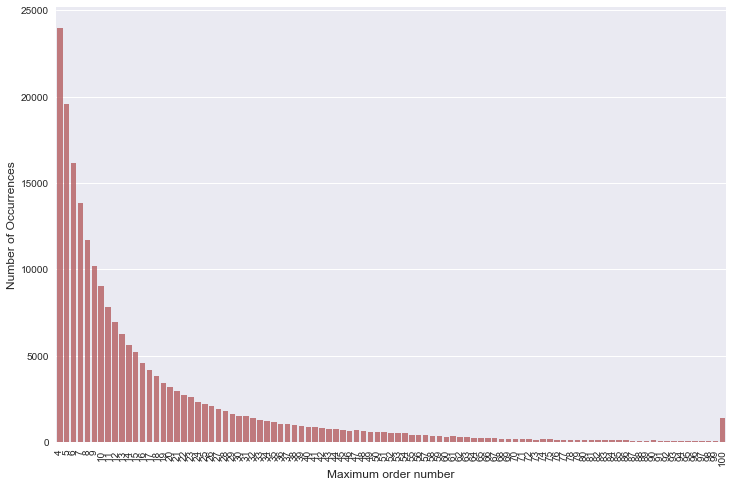

In [44]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()     
# 先ほどのgroupbyでの説明のように、今度は"usrer_id"毎にグループ分けして、それと対応する"order_number"をセットでDataFrameとして表示。
# ただし、"order_number"についてはnp.maxとaggregateを使って、でユーザー毎にグループわけしたそれぞれの"order_number"が一番大きい部分を抽出

cnt_srs = cnt_srs.order_number.value_counts()
# そして、たとえば、x件ならx件で「x件オーダーを出している人は何人いるか？」
# という集計を行い、件数順にソートしてインデックスを振り直してSeries型で返している。

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

4件より少ない注文数はない。また与えられたデータについては、100件の注文が上限になっている。

それでは、一週間において購入数がどう変動しているのかみてみよう。

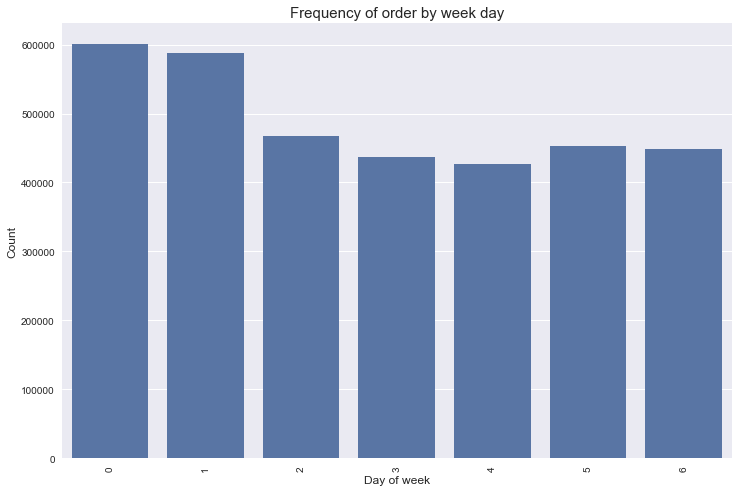

In [49]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow",data=orders_df,color=color[0])      
#x=order_dowとして曜日別にorderの数を表示。

plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

0と1はそれぞれ購入数の多い土曜日と日曜日を表しているようだ。そして水曜日は一日を通して購入数が少ない。購入の大多数は日中の時間帯に行われる。それでは、分布をみるためにday of week とhour of dayを一緒にしてみよう。

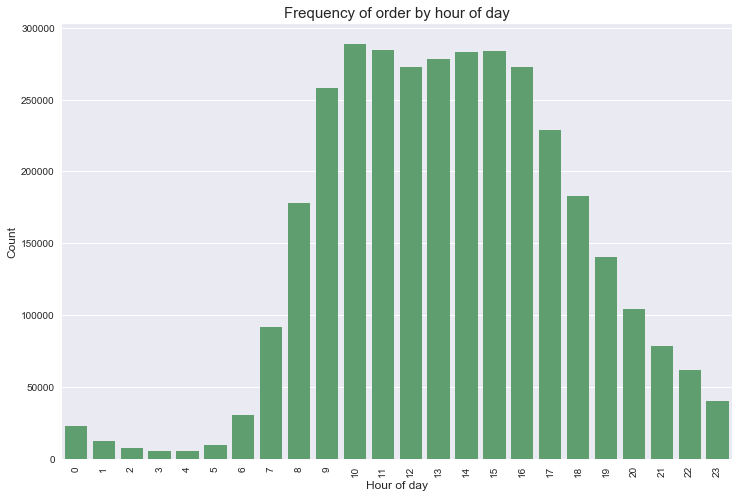

In [50]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

購入の大多数は日中の時間帯に行われる。それでは、分布をみるためにday of week とhour of dayを一緒にしてみよう。

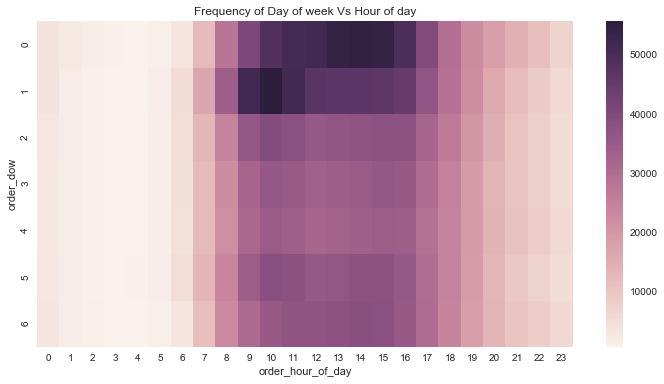

In [52]:
grouped_df=orders_df.groupby(["order_dow","order_hour_of_day"])["order_number"].aggregate("count").reset_index()   

grouped_df=grouped_df.pivot("order_dow","order_hour_of_day","order_number")
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)                   
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

土曜日の夜と日曜日の朝がゴールデンタイムのようだ。

それでは次に、ある注文から次の注文までの感覚をみてみよう。

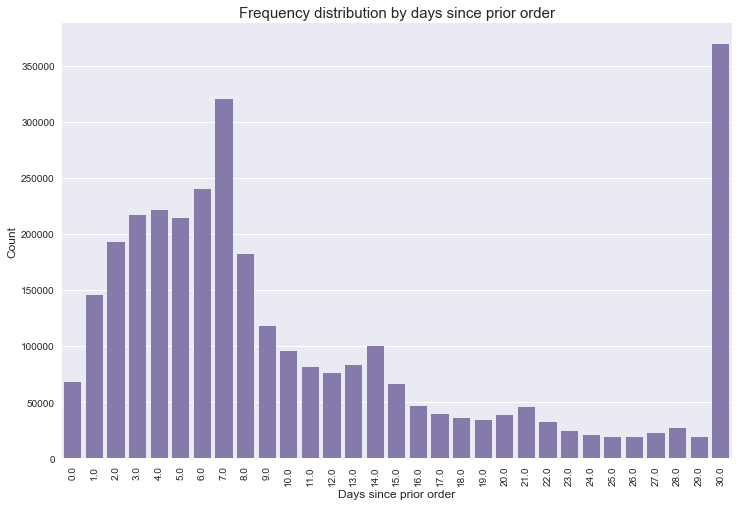

In [53]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

購入される周期は1週間に一度か一ヶ月に一度が多いようだ。(ピークが7日のところと、30日のところにあるのを確認せよ。)また、小さなピークが14日と21日と28日のところにもあるのがわかる。これは隔週での購入を表しているのだろう。

In [55]:
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

# reorderedは0か1を立てているので、.sum()をつかって、reorderされた件数が求まる。またshape[0]がreorderのところが0と1になっている合計なので
# 結果としてreorderされた分の割合を求めている。

0.5896974667922161

In [56]:
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

平均して、約59%の商品が再購入されているようだ。

# 再購入されていない製品

さて、59%の商品が再購入されていることをみたが、再購入されている商品がないということもあるだろう。それを確認してみよう。

In [60]:
grouped_df=order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
#"order_id"ごとにグループ分けして"reordered"のカラムを抽出。"order_id"ごとに合計してインデックスも振り直す。

grouped_df["reordered"].ix[grouped_df["reordered"]>1]=1
#  grouped_dfの"reorderd"のカラムから、ixメソッドで"reordered"の値が1より大きいところの行を返しそこに全て1を代入。

grouped_df.reordered.value_counts() / grouped_df.shape[0]
#  一個上の行で"reordered"が1以上のところには全て1を代入したので、それをもとに数え上げ。そしてパーセントの計算

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [62]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

#  同様。

1    0.93444
0    0.06556
Name: reordered, dtype: float64

トレーニング用のデータセットが6.5%に対して、以前の購入履歴データうちの約12%が再購入はされていない。

それぞれのデータセットに対して、購入された商品をみてみよう。

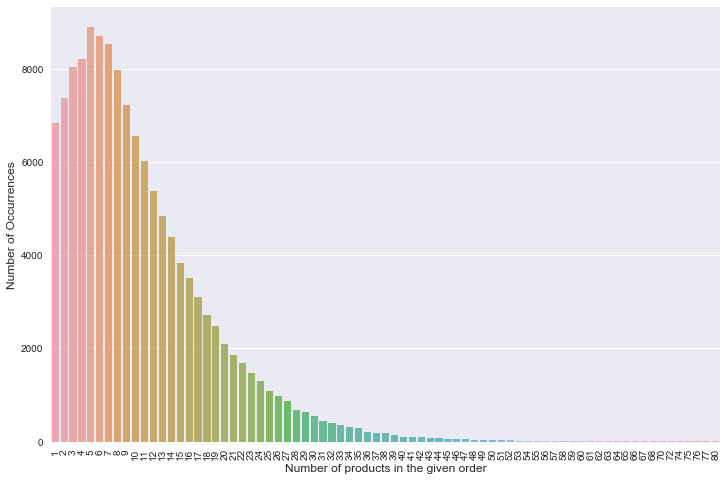

In [64]:
grouped_df=order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs=grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index,cnt_srs.values,alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

値5をもつ商品データをもつ右に裾のある分布だ。

商品の詳細をみていく前に、その他の3つのファイルも同様にみておこう。

In [65]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [67]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [68]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


では、order_product_priorファイルにこれらのファイルをマージしてみよう。

In [71]:
order_products_prior_df=pd.merge(order_products_prior_df,products_df,on="product_id",how="left")
order_products_prior_df=pd.merge(order_products_prior_df,aisles_df,on="aisle_id",how="left")
order_products_prior_df=pd.merge(order_products_prior_df,departments_df,on="department_id",how="left")
order_products_prior_df.head()

# product_dfとaisle_dfとdepartment_df  をorder_products_prior_dfに結合。
#どう結合しているのかっていうところは言葉では説明しにくいけど。

,order_id,product_id,add_to_cart_order,reordered,product_name_x,aisle_id_x,department_id_x,aisle_x,product_name_y,aisle_id_y,department_id_y,product_name,aisle_id,department_id,aisle_y,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,Organic Egg Whites,86,16,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,Michigan Organic Kale,83,4,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,Garlic Powder,104,13,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,Coconut Butter,19,13,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,Natural Sweetener,17,13,Natural Sweetener,17,13,baking ingredients,pantry


In [75]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs


# そのままなので、特にコメントなし。

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


なんということだ！ほとんどオーガニック製品じゃないか！しかもそのほとんどは果物だ！

次に重要なコーナーをみてみよう。

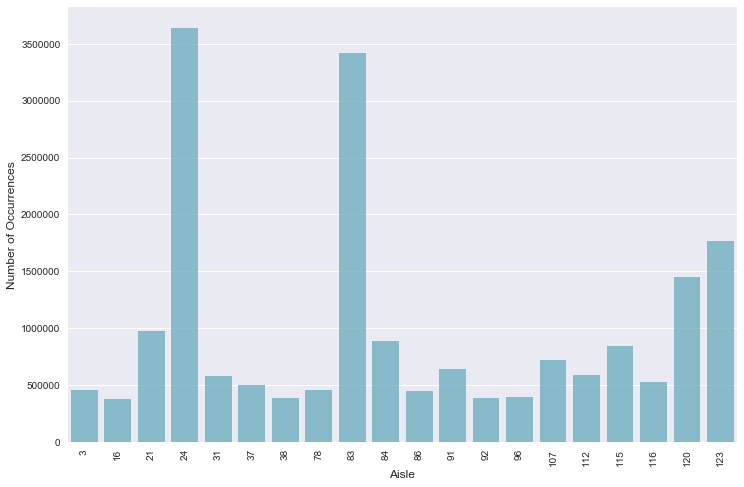

In [79]:
cnt_srs = order_products_prior_df['aisle_id'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()


# 今度は"aisle"別、つまり通路別に購入履歴をカウントしてる。

上位二つの通路は、果物のコーナーと野菜のコーナーだ。

# 部門ごとの分布

部門別の分布をみてみよう。

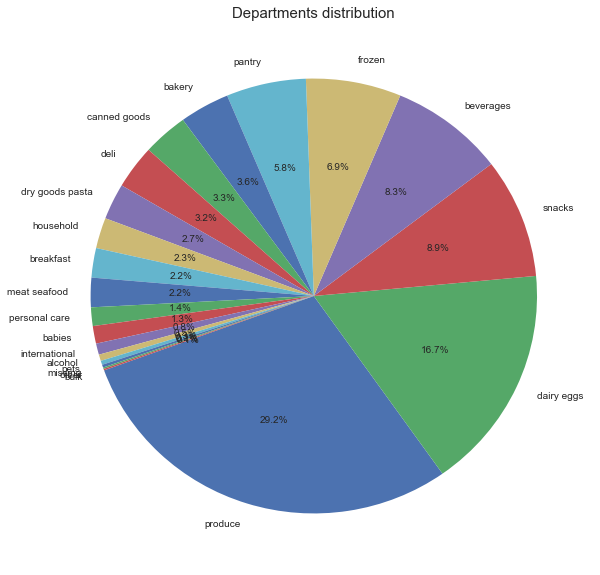

In [80]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

Produceが一番割合が大きい部門だ。では、部門別に再購入のパーセンテージをみてみよう。

# 部門別の再購入率

In [83]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

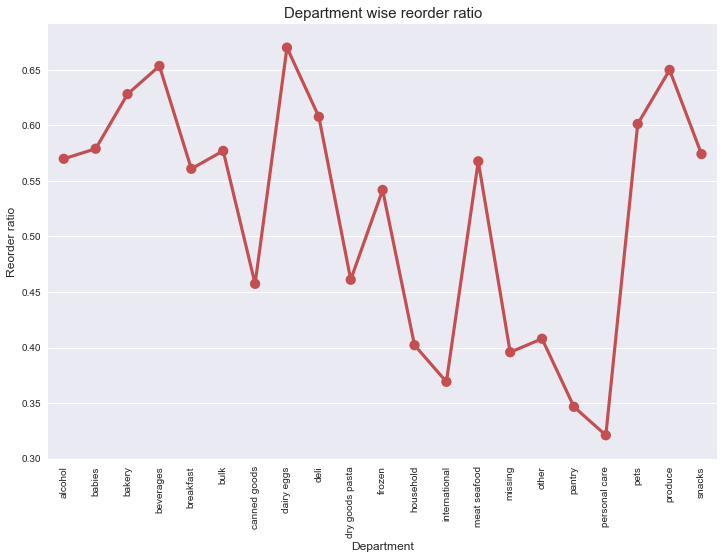

In [84]:
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

Personal careが最も低い割合で、dairy eggsが最も高い割合だ。

# コーナー別再購入率

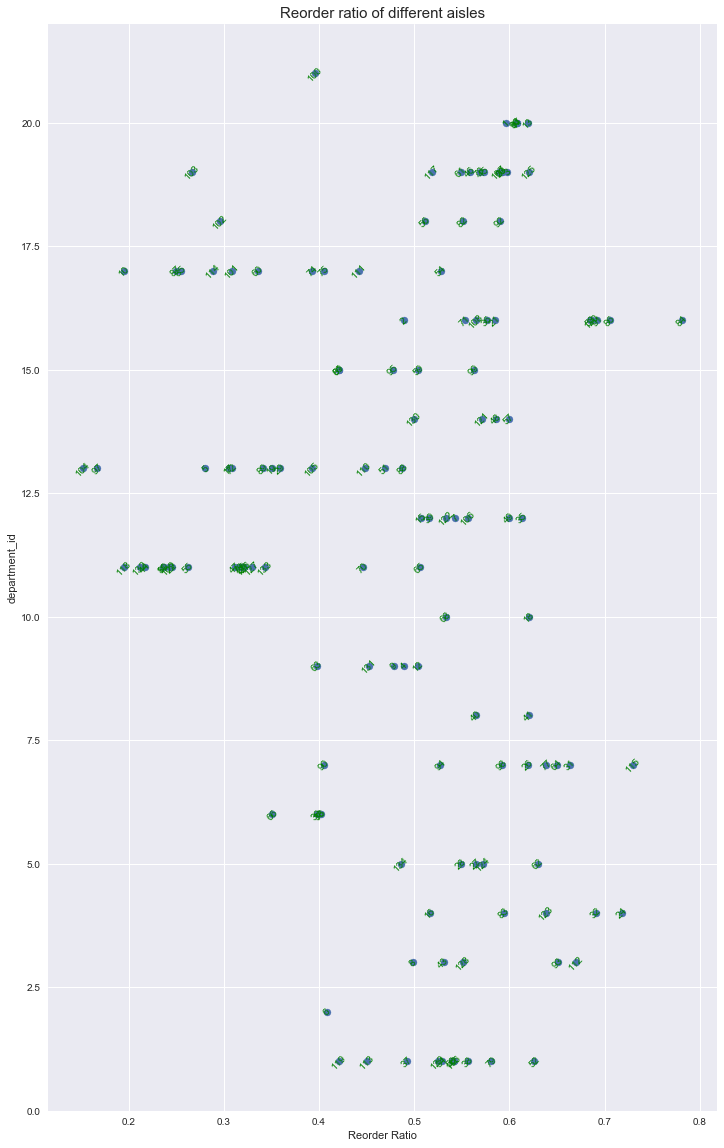

In [115]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle_id"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle_id.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

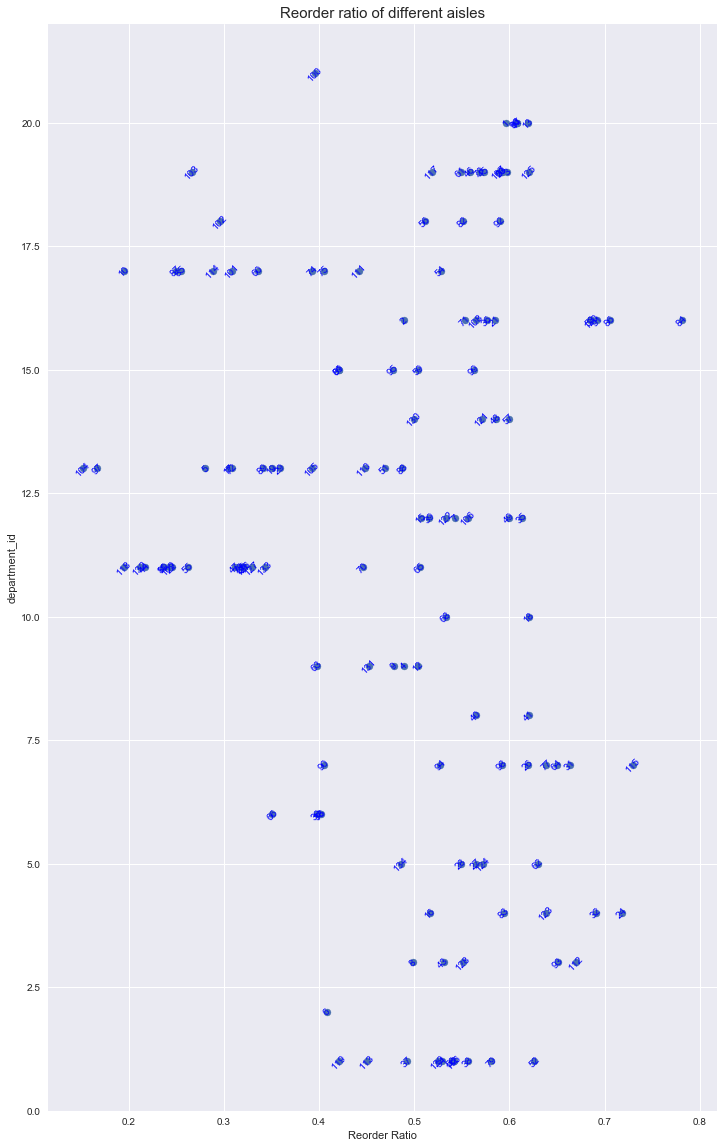

In [92]:
fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle_id.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='blue')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

# カートに入れたかどうかと再購入したかどうかの割合

それでは、カートに商品をいれたかどうかが再購入の割合にどう影響を及ぼしているのかという関係をみていこう。


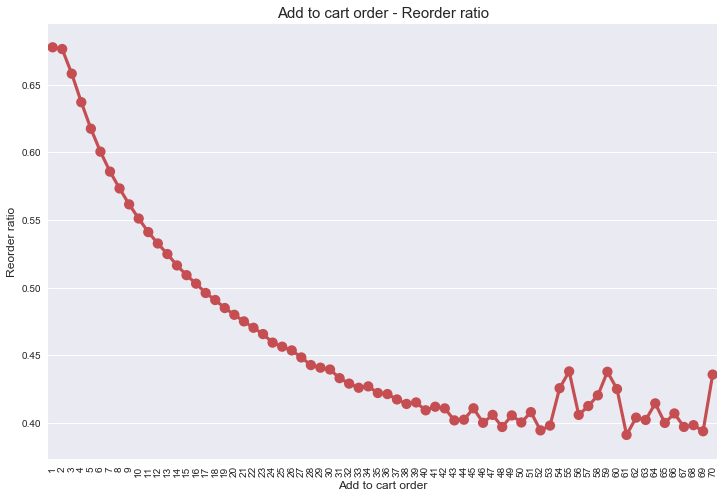

In [107]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
# order_products_prior_dfに新しいカラム"add_to_cart_order_mod"を追加。そこに、 order_products_prior_df["add_to_cart_order"]をコピー


order_products_prior_df["add_to_cart_order_mod"].ix[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
# 上限を丸め込むために、order_products_prior_df["add_to_cart_order_mod"]が70より大きいものはすべて70を代入。

grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()
# add_to_cart_orderの値ごとにグループ分けして(少し語弊があるけど)、reorderのカラムを抽出。でグループごとに中央値を返す。
#そのグループごとの中央値をreset_index()でまたインデックスを振り直し、あたらしいDataFrameにする。

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
#  grouped_df['add_to_cart_order_mod'].values  と
#  grouped_df['reordered'].values で折れ線グラフで描画。
# 以下はいろいろオプション。

plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

はじめにカートに入れられた商品のほうが、あとから入れられたものものより再購入されやすい傾向にあるようだ。これはなんとなくわかる。なぜなら、よく購入数する商品のほうを始めにカートにいれがちで、そのあとになにか新しいものを探しにいくからだ。


# 時間に基づく再購入履歴


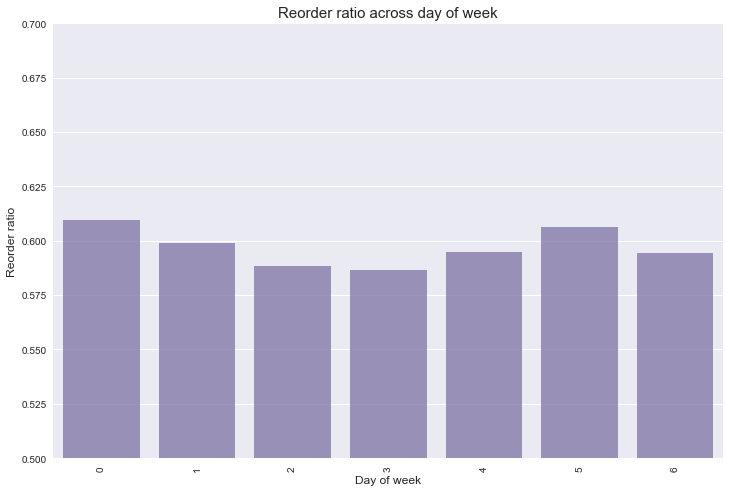

In [110]:
order_products_train_df=pd.merge(order_products_train_df,orders_df,on="order_id",how="left")
#  order_id を糊にして、order_products_train_dfとorders_dfを結合

grouped_df=order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()
# 曜日ごとにグループ分けして"reordered"のカラムを抽出。
#  そのグループごとに中央値を算出して新しいDataFrameを作成。

plt.figure(figsize=(12,8))
sns.barplot(grouped_df["order_dow"].values,grouped_df["reordered"].values,alpha=0.8,color=color[3])
#  grouped_df["order_dow"].values と  grouped_df["reordered"].valuesで棒グラフを作成。
#  以下はオプション。

plt.ylabel("Reorder ratio",fontsize=12)
plt.xlabel("Day of week",fontsize=12)
plt.title("Reorder ratio across day of week",fontsize=15)
plt.xticks(rotation="vertical")
plt.ylim(0.5,0.7)
plt.show()



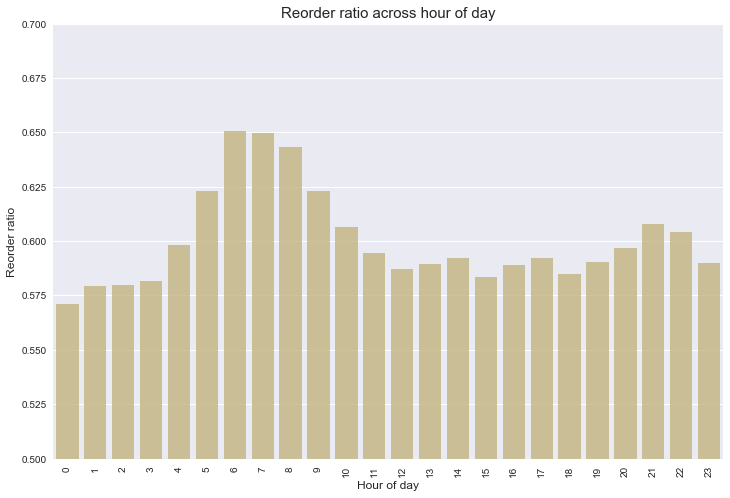

In [111]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

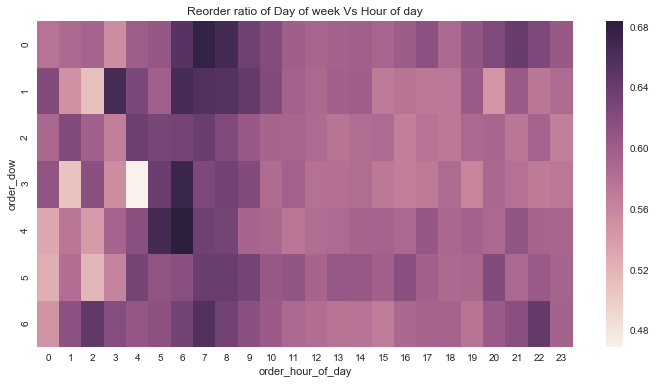

In [112]:
# 三つ以上の関係をみたいときはheatmap表示がよい。

grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

再購入率は、午後の時間帯よりも早朝の時間帯のほうが著しく高いようだ。